In [278]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pyflux as pf
fig = plt.figure(figsize=(20,15))
pd.set_option("display.max_columns",100)
pd.get_option("display.max_columns")
from pytrends.request import TrendReq
import itertools
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

<Figure size 1440x1080 with 0 Axes>

In [64]:
pytrends = TrendReq(hl='en-US', tz=360)

In [317]:
df = pd.read_excel('BLS_SA_Unemployment.xlsx',header=3)

In [318]:
ts_df = df.transpose()
ts_df = ts_df.iloc[1:]
ts_df.columns = ["seasonally_adjusted_unemployment_rate"]
date_rng = pd.date_range(start='1/1/1948', end='12/31/2018', freq='MS')
ts_df.index = date_rng
# ts_df = ts_df[ts_df.index.is_quarter_end == True]
ts_df.head()

,seasonally_adjusted_unemployment_rate
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4
1948-04-01,3.9
1948-05-01,3.5


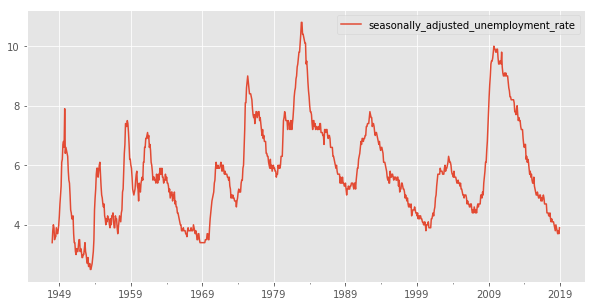

In [319]:
ts_df.plot(figsize=[10,5])

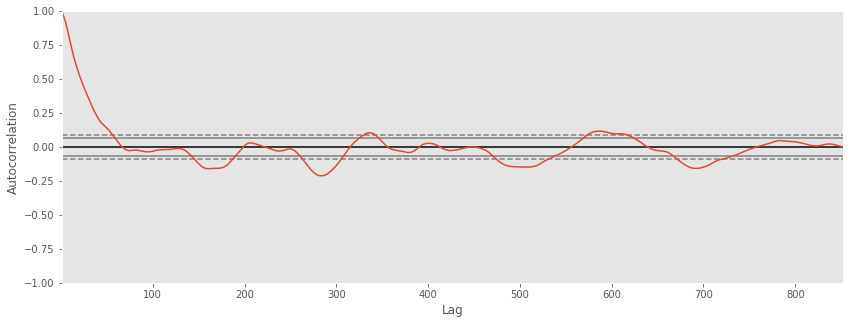

In [320]:
pd.plotting.autocorrelation_plot(ts_df)
# Autocorrelation = Matching our feature and time; How closely is the information given by time equal to the target feature
# Shows there is a high level of positive correlation between recent periods, but decays over time the correlation tends to center around the 0 mean
# Might need to consider adding additional normalization

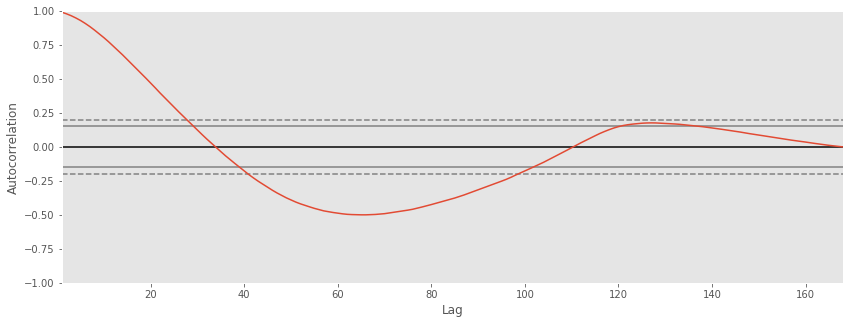

In [321]:
pd.plotting.autocorrelation_plot(df_UE)

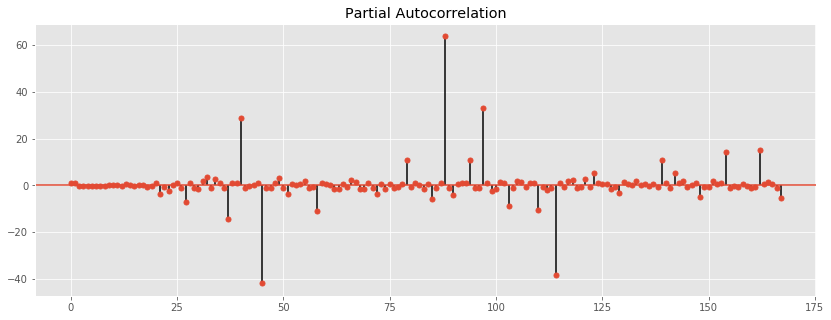

In [322]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(df_UE);

In [323]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [324]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,window=12):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean - {}'.format(str(window)))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std - {}'.format(str(window)))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

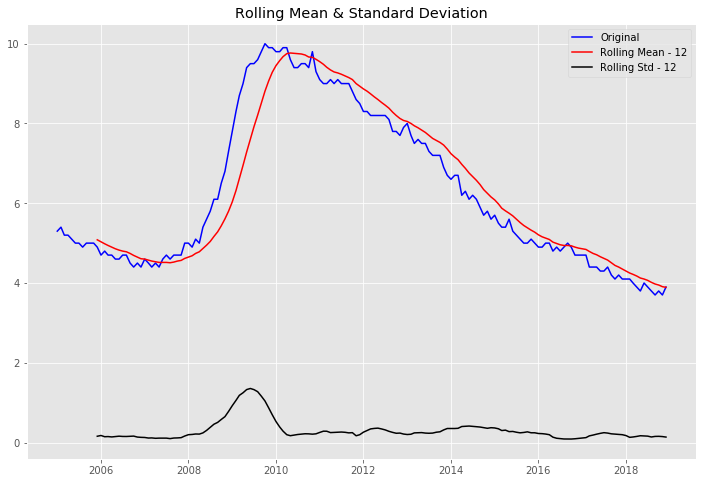

Results of Dickey-Fuller Test:
Test Statistic                  -2.091310
p-value                          0.248023
#Lags Used                       6.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


In [325]:
test_stationarity(df_UE.seasonally_adjusted_unemployment_rate)

In [326]:
# Difference formula

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [327]:
# First difference DF test return a p-value of .094; not good enough
df_UE_first = difference(df_UE.seasonally_adjusted_unemployment_rate)

In [328]:
# Will remove the rolling average as a naive attempt to reduce noise, but keep tendencies of the data

def use_rol_mean(pd_series, window=12):
    rolmean = pd_series.rolling(window).mean()
    data_minus_rolmean = pd_series - rolmean
    # Adding in rolmean creates NaNs for first year
    data_minus_rolmean.dropna(inplace=True)

    # Plot rollingmean
    fig = plt.figure(figsize=(11,7))
    orig = plt.plot(pd_series, color='blue',label='Original')
    plt.plot(data_minus_rolmean, color='red',label='Rolling mean - {}'.format(str(window)))
    plt.legend(loc='best')
    plt.title('Rolling means are subtracted from Original')
    plt.show(block=False)
    return data_minus_rolmean

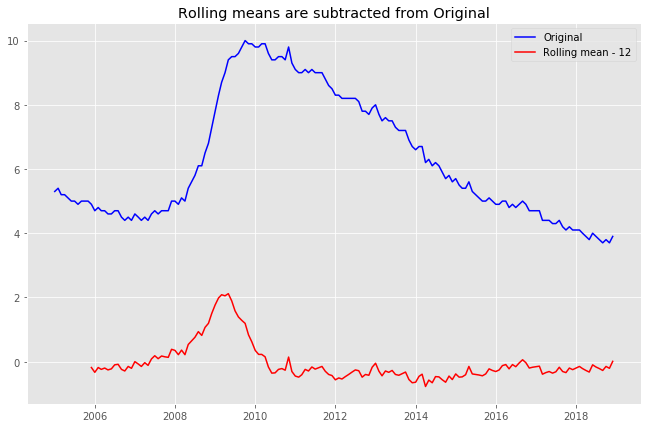

In [329]:
df_UE_rol_mean = use_rol_mean(df_UE,12)

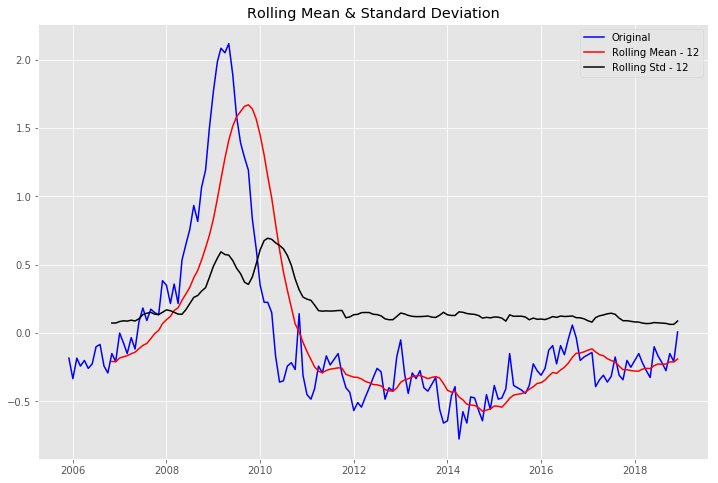

Results of Dickey-Fuller Test:
Test Statistic                  -2.796978
p-value                          0.058707
#Lags Used                       6.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


In [330]:
# I'm ok with 90% (actually 94+) confidence right now; 12 month lag
test_stationarity(df_UE_rol_mean.seasonally_adjusted_unemployment_rate)

In [334]:
df_UE_rol_mean['seasonally_adjusted_unemployment_rate'] = pd.to_numeric(df_UE_rol_mean.seasonally_adjusted_unemployment_rate)

In [335]:
df_UE_rol_mean.dtypes

seasonally_adjusted_unemployment_rate    float64
dtype: object

In [336]:
# Import job data
kw_list = ['job']
pytrends.build_payload(kw_list, cat=0, timeframe='2004-12-01 2018-12-31', geo='US', gprop='')
df_job_raw = pytrends.interest_over_time().drop("isPartial",axis=1)

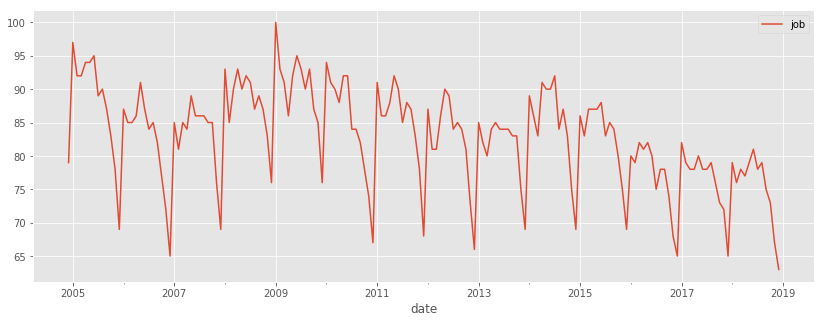

In [337]:
df_job_raw.plot()

In [338]:
df_job = df_job_raw

In [339]:
len(list(df_job.job.values)[:-1])

168

In [340]:
def raw_to_percent(data):
    columns = [100 * (b - a) / a for a, b in zip(list(df_job.job.values)[:-1], list(df_job.job.values)[1:])]
    return [0] + columns

In [341]:
df_job['job_search_change'] = raw_to_percent(df_job)
# remove first row and original column
df_job = df_job.iloc[1:,1:]

In [342]:
df_job.head()

,job_search_change
date,
2005-01-01,22.784810
2005-02-01,-5.154639
2005-03-01,0.000000
2005-04-01,2.173913
2005-05-01,0.000000


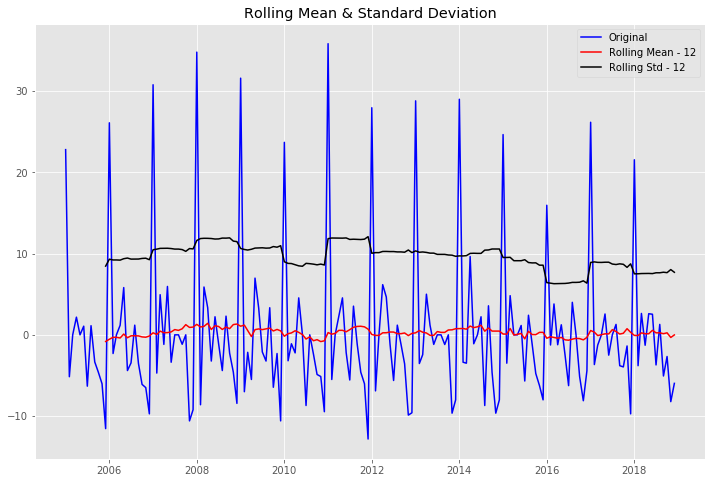

Results of Dickey-Fuller Test:
Test Statistic                  -3.088251
p-value                          0.027435
#Lags Used                      14.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64


In [343]:
test_stationarity(df_job.job_search_change)

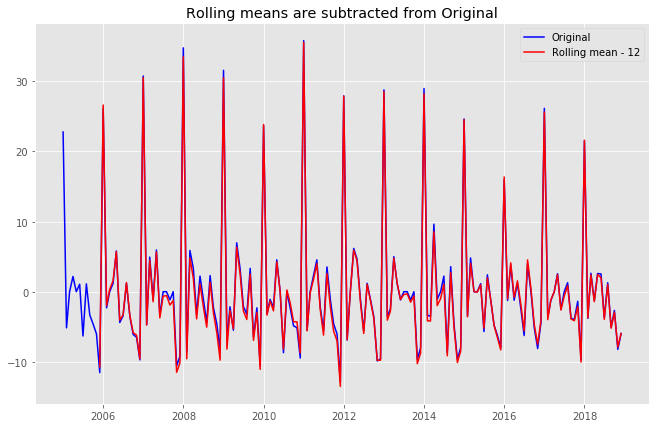

In [344]:
df_job_rol_mean = use_rol_mean(df_job,12)

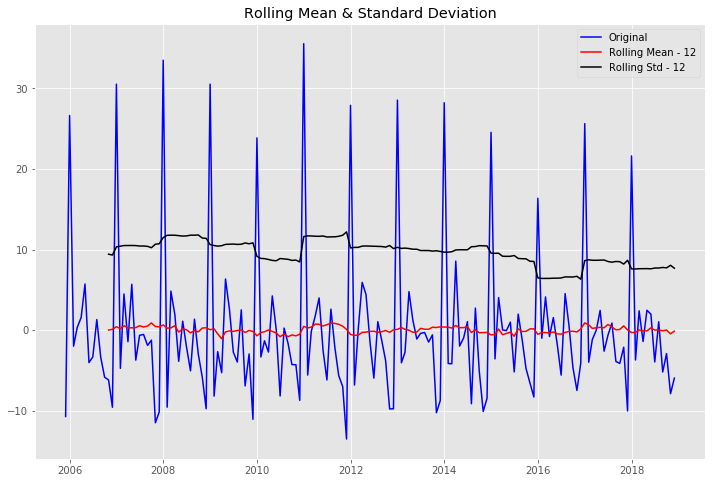

Results of Dickey-Fuller Test:
Test Statistic                  -3.917964
p-value                          0.001907
#Lags Used                      14.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [345]:
test_stationarity(df_job_rol_mean.job_search_change)

In [346]:
# Combine dataframe

df_ue_js = df_UE_rol_mean.join(df_job_rol_mean)

In [347]:
df_ue_js.columns = ['unempl_rate (12mn RA)','job_search_rate (12mn RA)']

In [361]:
len(ts_train) == len(ex_train.reshape([1,-1]))

False

In [431]:
ex_test

array([-2.91465613])

In [434]:
# SARIMAX example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

training_range_end = '2018-09-30'
testing_range_start = '2018-10-01'
testing_range_end = '2018-10-31'

ts_train = df_ue_js.loc[:training_range_end,'unempl_rate (12mn RA)'].values
ts_test = df_ue_js.loc[testing_range_start:,'unempl_rate (12mn RA)'].values
ex_train = df_ue_js.loc[:training_range_end,'job_search_rate (12mn RA)'].values
ex_test = df_ue_js.loc[testing_range_start:testing_range_end,'job_search_rate (12mn RA)'].values

data1 = ts_train
exog1 = ex_train

# fit model
model = SARIMAX(data1, exog=exog1, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit()

# make prediction
exog2 = ex_test
yhat = model_fit.predict('2018-09-01', exog=[exog2])
print(yhat)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

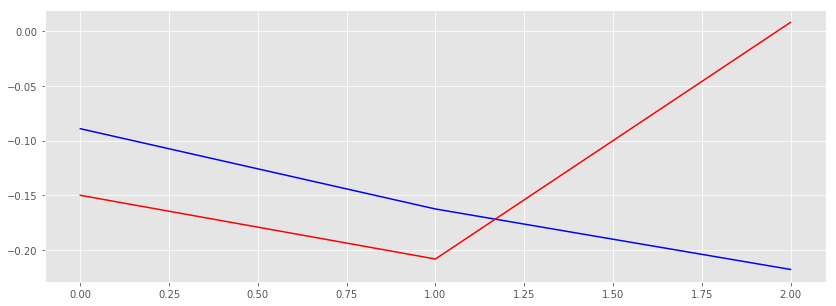

In [428]:
plt.plot(range(0,len(yhat)),yhat,color='blue')
plt.plot(range(0,len(ts_test)),ts_test,color='red')

In [405]:
ex_test

array([-7.89639129, -5.96003521])

In [11]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [384]:
ts_train.shape

(155,)

In [385]:
data2.shape

(1, 155)

In [382]:
ts_df_input.shape

(168,)

In [12]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_df_input,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue


ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5464.770184245424
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4439.909301148371
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =2683.3404004578333
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =2602.2964627253364
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =2679.9423681686003


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =2678.609015233141
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =2608.0204433540903
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =2590.9909771260172
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =4305.604430265357
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =3350.874315922722
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1785.9761813753578
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =1708.825228198561
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1781.3633367017596
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =1775.270566469567
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =1726.9536176037504
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =1709.725706656513
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =-250.66463354169196
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =-278.14820551184835
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =457.8430612526822
ARIMA (0, 1

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =-338.54165246574473
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =129.03039731844123
ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =-200.0275549824296
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =-255.72328650169942
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =-284.89384047096667
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =455.0923485109562
ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =-268.38602081099236
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =-270.3485338474235
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =-349.752868669832
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =116.85886955024574
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =-206.7199659699501
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =-246.49758343538292


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =-239.64592317907756
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =444.2162107595335
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-253.101040121241
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-262.6507012374916
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-271.36605386963765
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =120.87146798850668
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-198.2182265746288
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =-254.3824106190134


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =-245.6933502289083
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =439.60495865413685
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-269.68453361142485
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-268.58750147227556
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-281.7034430291972
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =106.99290218905054
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =-206.67380403538675
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =-260.47613524451225
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =-289.754100996121
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =451.8334174129506


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =-275.24398506009805
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =-278.30078109545514
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =-356.0000439884905
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =106.13107378139566
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =-210.1737924136549
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =-323.03662741264634
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =-372.0066661689764
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =400.25877887516396


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =-344.20362238116655
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =-357.5058092987767
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =-432.3074018824609
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =35.68350514814185
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =-289.977660797269


In [ ]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
ans_df.loc[ans_df['aic'].idxmin()][0]

In [ ]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts_df_input,
                                order=ans_df.loc[ans_df['aic'].idxmin()][0],
                                seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
def arima_modeler(data,pdq_lower,pdq_upper,m):
    p = d = q = range(pdq_lower, pdq_upper)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts_df_input,
                                order=ans_df.loc[ans_df['aic'].idxmin()][0],
                                seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])
    return output

In [ ]:
arima_unemployment = arima_modeler(ts_df_input,0,2,12)

In [ ]:
arima_unemployment.plot_diagnostics()

In [ ]:
type(arima_unemployment)

In [ ]:
test_stationarity(ts_df_input)